 <h1><center> <font color='green'>CNN-GAN
 
 </font></center></h1> 

 <h1><center> <font color='blue'>Librerías</font></center></h1>

In [2]:
'''OpenCV proporciona funcionalidad enfocada en el desarrollo de aplicaciones de Vision Artificial.'''
import cv2
'''librerías que agregan soporte para abrir, manipular y guardar muchos formatos de archivos de imágenes diferentes.'''
from PIL import Image
import os
from imageio import imread, imwrite
"""Librería para calculo numerico"""
import numpy as np
'''Librería para las gráficas'''
import matplotlib.pyplot as plt
np.random.seed(5)
"""keras para las redes neuronales"""
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input
from keras.layers.core import Activation
from tensorflow.keras.optimizers import Adam

<h1><center> <font color='orange'>Carga y exploración de datos</font></center></h1> 

In [11]:
'''Se especifican las direcciones de las carpetetas'''
dataset = "/content/drive/MyDrive/Mineria/vocales128x128"
ejemplos = "/content/drive/MyDrive/Mineria/vocales_Ejemplo"

In [12]:
'''Se lee y se imprimen la cantidad de las imagenes'''
categories = os.listdir(dataset)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['a_077.jpg', 'a_093.jpg', 'a_121.jpg', 'a_083.jpg', 'a_013.jpg', 'a_069.jpg', 'a_070.jpg', 'a_141.jpg', 'a_177.jpg', 'a_034.jpg', 'a_105.jpg', 'a_098.jpg', 'a_145.jpg', 'a_170.jpg', 'a_104.jpg', 'a_114.jpg', 'a_022.jpg', 'a_167.jpg', 'a_117.jpg', 'a_161.jpg', 'a_162.jpg', 'a_149.jpg', 'a_079.jpg', 'a_116.jpg', 'a_147.jpg', 'a_160.jpg', 'a_051.jpg', 'a_052.jpg', 'a_007.jpg', 'a_010.jpg', 'a_020.jpg', 'a_122.jpg', 'a_175.jpg', 'a_063.jpg', 'a_005.jpg', 'a_031.jpg', 'a_166.jpg', 'a_174.jpg', 'a_011.jpg', 'a_106.jpg', 'a_014.jpg', 'a_082.jpg', 'a_053.jpg', 'a_130.jpg', 'a_139.jpg', 'a_030.jpg', 'a_120.jpg', 'a_097.jpg', 'a_061.jpg', 'a_150.jpg', 'a_002.jpg', 'a_179.jpg', 'a_057.jpg', 'a_043.jpg', 'a_049.jpg', 'a_165.jpg', 'a_062.jpg', 'a_025.jpg', 'a_123.jpg', 'a_151.jpg', 'a_119.jpg', 'a_009.jpg', 'a_127.jpg', 'a_111.jpg', 'a_100.jpg', 'a_126.jpg', 'a_023.jpg', 'a_171.jpg', 'a_035.jpg', 'a_064.jpg', 'a_146.jpg', 'a_008.jpg', 'a_067.jpg', 'a_081.jpg', 'a_046.jpg', 'a

<h1><center> <font color='brow'>Definición del conjunto de datos de entrenamiento</font></center></h1>

In [13]:
'''Método para la creación del set de entrenamiento'''
def cargar_datos():
    print('Creando set de entrenamiento...',end="",flush=True)
    filelist = os.listdir(dataset)

    n_imgs = len(filelist)
    x_train = np.zeros((n_imgs,128,128,3))

    for i, fname in enumerate(filelist):
        if fname != '.DS_Store':
            imagen = imread(os.path.join(dataset,fname))
            x_train[i,:] = (imagen - 127.5)/127.5
    print('¡Listo!')

    return x_train

In [14]:

'''Método para la visualziación del conjunto de entrenamiento'''
def visualizar_imagen(nimagen,x_train):
    imagen = (x_train[nimagen,:]*127.5) + 127.5
    imagen = np.ndarray.astype(imagen, np.uint8)
    plt.imshow(imagen.reshape(128,128,3))
    plt.axis('off')
    plt.show()

In [15]:

'''Método para la visualización de algunas imagenes obtenidas con el generador'''
def graficar_imagenes_generadas(epoch, generador, ejemplos=16, dim=(4,4), figsize=(10,10)):
    ruido = np.random.normal(0,1,[ejemplos,100])
    imagenes_generadas = generador.predict(ruido)
    imagenes_generadas.reshape(ejemplos,128,128,3)
    imagenes_generadas = imagenes_generadas*127.5 + 127.5
    plt.figure(figsize=figsize)
    for i in range(ejemplos):
        plt.subplot(dim[0],dim[1], i+1)
        plt.imshow(imagenes_generadas[i].astype('uint8'), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('GAN_imagen_generada_%d.jpg' %epoch)
    plt.close()

In [16]:
'''Método para la generación de las imágenes ejemplo'''
def generar_imagenes(generador,nimagenes):
    ruido = np.random.normal(0,1,[nimagenes,100])
    imagenes_generadas = generador.predict(ruido)
    imagenes_generadas.reshape(nimagenes,128,128,3)
    imagenes_generadas = imagenes_generadas*127.5 + 127.5
    imagenes_generadas.astype('uint8')
    for i in range(nimagenes):
        imwrite(os.path.join(ejemplos,'imagen_'+str(i)+'.jpg'),imagenes_generadas[i].reshape(128,128,3))

In [17]:
'''Inicialización de los hiperparámetros para el entrenamiento del modelo'''
OPTIMIZADOR = Adam(lr=0.0002, beta_1=0.5)
TAM_ENTRADA = 100
ERROR = 'binary_crossentropy'
LEAKY_SLOPE = 0.2
TAM_LOTE = 128 
N_ITS = 6000

Creando set de entrenamiento...¡Listo!


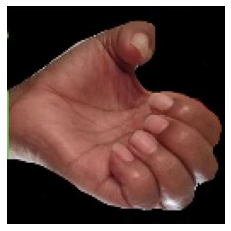

In [18]:
'''Creación del conjunto de entrenamiento'''
x_train = cargar_datos()
'''Visualización de una imagen del conjunto de entrenamiento. Especificamente se visualiza la imagen 250'''
visualizar_imagen(250,x_train)

 <h1><center> <font color='purple'>Implementación del modelo </font></center></h1> 

### GENERADOR GAN

In [19]:
'''Método generador, el cuál contiene el método, el cual fabrica
artificialmente resultados que podrían confundirse fácilmente con datos reales.'''
def crear_generador():
    modelo = Sequential()
    modelo.add(Dense(1024*4*4, use_bias=False, input_shape=(TAM_ENTRADA,)))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Reshape((4,4,1024)))
    

    modelo.add(Conv2DTranspose(512,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2DTranspose(3, (5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(Activation('tanh'))

    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

generador = crear_generador()


### DISCRIMINADOR GAN

In [20]:
'''Método discriminador el cual ayuda al generador a crear cada vez mejores imágenes.'''
def crear_discriminador():
    modelo = Sequential()
    modelo.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(128,128,3),
        use_bias=False))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2D(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2D(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2D(512, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2D(1024, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

discriminador = crear_discriminador()


### GAN

In [21]:
'''Método para crear el modelo GAN'''
def crear_GAN(generador, discriminador):
    modelo = Sequential()
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

gan = crear_GAN(generador, discriminador)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       19120576  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 17436864  
                                                                 
Total params: 36,557,440
Trainable params: 19,085,888
Non-trainable params: 17,471,552
_________________________________________________________________


# Entrenamiento del Modelo

In [23]:
'''Entrenamiento del modelo'''
n_lotes = x_train.shape[0]/TAM_LOTE

for i in range(1,N_ITS+1):
    print("Epoch " + str(i))

    #Se crea un "batch" de imágenes falsas y otro con imágenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    batch_falsas = generador.predict(ruido)

    idx = np.random.randint(low=0, high=x_train.shape[0],size=TAM_LOTE)
    batch_reales = x_train[idx]

    #Se entrenar discriminador con imagener falsas y reales, y en cada
    discriminador.trainable = True

    dError_reales = discriminador.train_on_batch(batch_reales,
        np.ones(TAM_LOTE)*0.9)
    dError_falsas = discriminador.train_on_batch(batch_falsas,
        np.zeros(TAM_LOTE)*0.1)

    discriminador.trainable = False
    #Entrenamiento de GAN en donde se genera ruido aleatorio y se repesenta en GAN como si fuese imágenes reales

    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    gError = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

    if i==1 or i%1000 == 0:
        graficar_imagenes_generadas(i,generador)
        generador.save('generador.h5')

generar_imagenes(generador,200)

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 1001
Epoch 1002
Epoch 1003
Epoch 1004
Epoch 1005
Epoch 1006
Epoch 1007
Epoch 1008
Epoch 1009
Epoch 1010
Epoch 1011
Epoch 1012
Epoch 1013
Epoch 1014
Epoch 1015
Epoch 1016
Epoch 1017
Epoch 1018
Epoch 1019
Epoch 1020
Epoch 1021
Epoch 1022
Epoch 1023
Epoch 1024
Epoch 1025
Epoch 1026
Epoch 1027
Epoch 1028
Epoch 1029
Epoch 1030
Epoch 1031
Epoch 1032
Epoch 1033
Epoch 1034
Epoch 1035
Epoch 1036
Epoch 1037
Epoch 1038
Epoch 1039
Epoch 1040
Epoch 1041
Epoch 1042
Epoch 1043
Epoch 1044
Epoch 1045
Epoch 1046
Epoch 1047
Epoch 1048
Epoch 1049
Epoch 1050
Epoch 1051
Epoch 1052
Epoch 1053
Epoch 1054
Epoch 1055
Epoch 1056
Epoch 1057
Epoch 1058
Epoch 1059
Epoch 1060
Epoch 1061
Epoch 1062
Epoch 1063
Epoch 1064
Epoch 1065
Epoch 1066
Epoch 1067
Epoch 1068
Epoch 1069
Epoch 1070
Epoch 1071
Epoch 1072
Epoch 1073
Epoch 1074
Epoch 1075
Epoch 1076
Epoch 1077
Epoch 1078
Epoch 1079
Epoch 1080
Epoch 1081
Epoch 1082
Epoch 1083
Epoch 1084
Epoch 1085
Epoc